In [1]:
#meta 12/29/2020 Kaggle Cassava Dataprep - Imbalanced dataset -> Oversample with SMOTE
#fast.ai 2020 study group Kaggle Competition
#src https://www.kaggle.com/c/cassava-leaf-disease-classification
#prev competition src https://www.kaggle.com/c/cassava-disease
#references https://arxiv.org/pdf/1908.02900.pdf

#input: kaggle files - images, csv with 5 cats
#output: n/a
#pwd: /kaggle/working
#based on: my-kaggle-cassava-0-dataprep.ipynb

#history
#here 1/3/2020 IMBALANCED DS -> OVERSAMPLE WITH SMOTE
#     src https://www.kaggle.com/zakraicik/fast-ai-starter-w-smote-resample


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#oversampling
from imblearn.over_sampling import SMOTE

#modeling
from fastai.vision.all import *


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
i=0
'''for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if not 'jpg' in filename:
            print(os.path.join(dirname, filename))
        else:
            
            if i<5:
                print (os.path.join(dirname, filename))
                i += 1
'''

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"for dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        if not 'jpg' in filename:\n            print(os.path.join(dirname, filename))\n        else:\n            \n            if i<5:\n                print (os.path.join(dirname, filename))\n                i += 1\n"

In [3]:
#Global objects
#--constants and variables
SEED = 24

#--functions
#define label lookup 
def lookup_label(image_id): return int(df_train[df_train['image_id']== image_id]['label'])

#test function
#lookup_label('100042118.jpg')

# Cassava Disease Classification
##### Objective: Classify pictures of cassava leaves into 1 of 4 disease categories or healthy.

As the second-largest provider of carbohydrates in Africa, cassava is a key food security crop grown by smallholder farmers because it can withstand harsh conditions. At least 80% of household farms in Sub-Saharan Africa grow this starchy root, but viral diseases are major sources of poor yields. With the help of data science, it may be possible to identify common diseases so they can be treated.

Existing methods of disease detection require farmers to solicit the help of government-funded agricultural experts to visually inspect and diagnose the plants. This suffers from being labor-intensive, low-supply and costly. As an added challenge, effective solutions for farmers must perform well under significant constraints, since African farmers may only have access to mobile-quality cameras with low-bandwidth.

In this competition, we introduce a dataset of 21,367 labeled images collected during a regular survey in Uganda. Most images were crowdsourced from farmers taking photos of their gardens, and annotated by experts at the National Crops Resources Research Institute (NaCRRI) in collaboration with the AI lab at Makerere University, Kampala. This is in a format that most realistically represents what farmers would need to diagnose in real life.

Your task is to classify each cassava image into four disease categories or a fifth category indicating a healthy leaf. With your help, farmers may be able to quickly identify diseased plants, potentially saving their crops before they inflict irreparable damage.


## 0. Data

- Input: a dataset of 21,367 labeled images collected during a regular survey in Uganda.  
- Output: 5 categories, including healthy + 4 fine-grained cassava leaf disease categories

In [4]:
path = Path('../input/cassava-leaf-disease-classification')
#path.ls()

### 0.1 Images  
train images

In [5]:
#load temp train images
train_img = get_image_files(path)

print("Number of files: ", len(train_img))

Number of files:  21398


### 0.2 Disease Labels Mapping

In [6]:
with open((path/'label_num_to_disease_map.json')) as json_file:
    target_map = json.load(json_file)
    
print(target_map)

{'0': 'Cassava Bacterial Blight (CBB)', '1': 'Cassava Brown Streak Disease (CBSD)', '2': 'Cassava Green Mottle (CGM)', '3': 'Cassava Mosaic Disease (CMD)', '4': 'Healthy'}


### 0.3 Train Dataset
Full train set

In [7]:
df_train = pd.read_csv(path/'train.csv')
print('train data\n', df_train.shape)
display(df_train.head())


train data
 (21397, 2)


,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


0     1087
1     2189
2     2386
3    13158
4     2577
Name: label, dtype: int64


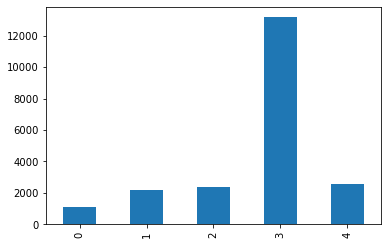

In [8]:
print(df_train['label'].value_counts().sort_index())
df_train['label'].value_counts().sort_index().plot(kind='bar');

1
../input/cassava-leaf-disease-classification/train_images/100042118.jpg


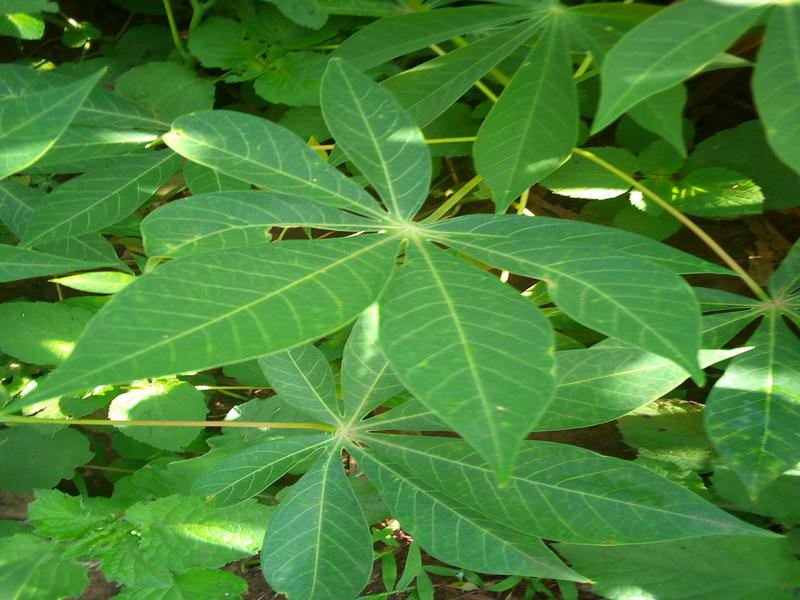

In [9]:
#view an image
image_example = '100042118.jpg'
print(lookup_label(image_example))
print(path/'train_images'/image_example)
Image.open(path/'train_images'/image_example)


## 1. Data Prep
Imbalanced dataset -> prepare for oversampling with SMOTE


In [10]:
print("before: ", df_train.dtypes)
df_train['image_id_cat'] = df_train['image_id']
df_train['image_id_cat'] = df_train['image_id_cat'].astype('category')
df_train['image_id_cat_code'] = df_train['image_id_cat'].cat.codes
print("after: ", df_train.dtypes)

before:  image_id    object
label        int64
dtype: object
after:  image_id               object
label                   int64
image_id_cat         category
image_id_cat_code       int16
dtype: object


In [11]:
df_train.iloc[::100]

,image_id,label,image_id_cat,image_id_cat_code
0,1000015157.jpg,0,1000015157.jpg,0
100,101712540.jpg,2,101712540.jpg,100
200,1037337861.jpg,3,1037337861.jpg,200
300,1053009170.jpg,3,1053009170.jpg,300
400,1072471707.jpg,3,1072471707.jpg,400
...,...,...,...,...
20900,900415263.jpg,3,900415263.jpg,20900
21000,918675350.jpg,3,918675350.jpg,21000
21100,939861475.jpg,3,939861475.jpg,21100
21200,959863341.jpg,3,959863341.jpg,21200


### 1.0 Oversample with Smote

In [12]:
sm = SMOTE(random_state=2)
#X_res, y_res = sm.fit_resample(df_train.iloc[:,0], df_train['label'])
X_res, y_res = sm.fit_resample(df_train[['image_id_cat_code','label']], df_train['label'])

X_res.__class__, y_res.__class__

(pandas.core.frame.DataFrame, pandas.core.series.Series)

In [13]:
y_label = 'label'
X_cols = df_train[['image_id_cat_code','label']].columns.tolist()

df_train_res = pd.DataFrame(data = X_res,columns = X_cols)
df_train_res[y_label] = y_res
df_train_res.shape

(65790, 2)

In [14]:
#view oversampled data
X_res.iloc[21398:36398,:500], X_res.iloc[36399:46399,:500], X_res.iloc[46400:,:500]

(       image_id_cat_code  label
 21398              14295      0
 21399              10154      0
 21400               4592      0
 21401              13337      0
 21402              18681      0
 ...                  ...    ...
 36393              12030      1
 36394               7893      1
 36395              13645      1
 36396              13981      1
 36397              15887      1
 
 [15000 rows x 2 columns],
        image_id_cat_code  label
 36399              10162      1
 36400              11910      1
 36401                751      1
 36402               4310      1
 36403              15359      1
 ...                  ...    ...
 46394               6854      2
 46395               2705      2
 46396              17987      2
 46397              12571      2
 46398              15960      2
 
 [10000 rows x 2 columns],
        image_id_cat_code  label
 46400               1194      2
 46401              16411      2
 46402               7954      2
 46403            

In [15]:
df_train_res.tail()

,image_id_cat_code,label
65785,13099,4
65786,4130,4
65787,8794,4
65788,16123,4
65789,10743,4


0    13158
1    13158
2    13158
3    13158
4    13158
Name: label, dtype: int64


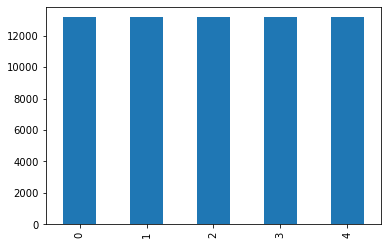

In [16]:
print(df_train_res['label'].value_counts().sort_index())
df_train_res['label'].value_counts().sort_index().plot(kind='bar');

In [17]:
#lookup image_id
idx2img = pd.Series(df_train['image_id'].values,index=df_train['image_id_cat_code']).to_dict()
idx2img[0]

'1000015157.jpg'

In [18]:
df_train_tidy = df_train_res.copy()
print(df_train_tidy.shape)
df_train_tidy['image_id_res'] = df_train_tidy['image_id_cat_code']
print(df_train_tidy.shape)
df_train_tidy['image_id_res'].replace(idx2img, inplace=True)
df_train_tidy.head(), df_train_tidy.iloc[21398:21403]

(65790, 2)
(65790, 3)


(   image_id_cat_code  label    image_id_res
 0                  0      0  1000015157.jpg
 1                  1      3  1000201771.jpg
 2                  2      1   100042118.jpg
 3                  3      1  1000723321.jpg
 4                  4      3  1000812911.jpg,
        image_id_cat_code  label    image_id_res
 21398              14295      0  3556554979.jpg
 21399              10154      0  2810190903.jpg
 21400               4592      0  1821756534.jpg
 21401              13337      0  3385271207.jpg
 21402              18681      0   492140725.jpg)

### 1.1b From Data to Dataloaders
See Ch.2 with DataBlock  
Diff ways to transform images

In [19]:
#def get_x(row): return path/row['image_id']
def get_x(row): return path/'train_images'/row['image_id_res']
def get_y(row): return row['label']

In [20]:
dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_x = get_x,
                 get_y = get_y,
                splitter=RandomSplitter(valid_pct=0.0, seed=42),
                 item_tfms = Resize(224))

65790 0


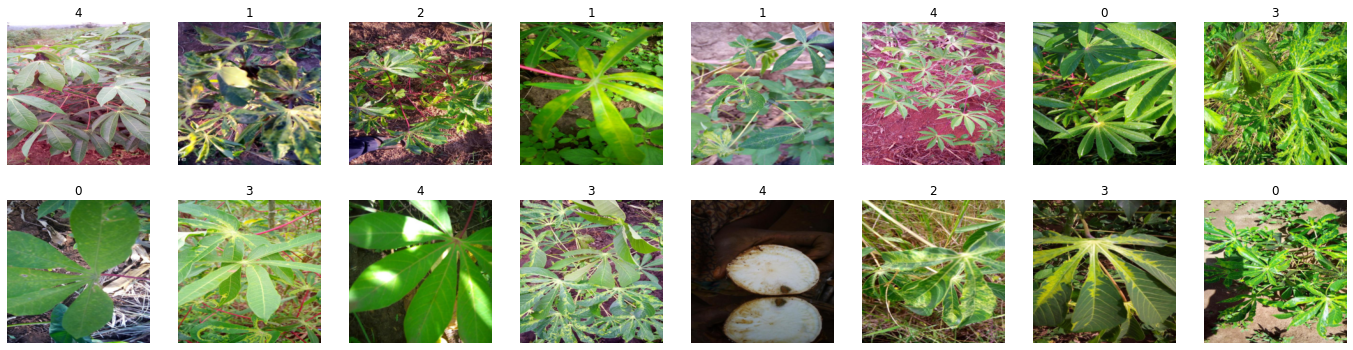

In [21]:
dls = dblock.dataloaders(df_train_tidy[['image_id_res', 'label']], bs=64)
print(len(dls.train_ds), len(dls.valid_ds))
dls.train.show_batch(max_n=16, nrows=2)

### 1.1c Center Crop

Try on one image

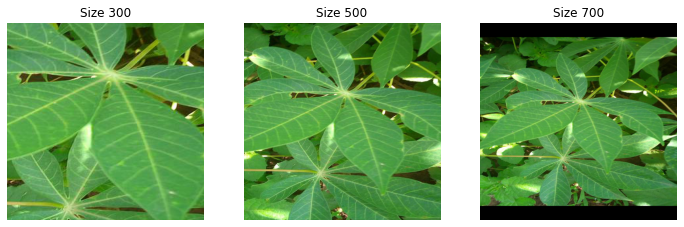

In [22]:
img = Image.open(path/'train_images'/image_example)
_,axs = plt.subplots(1,3,figsize=(12,4))
for ax,sz in zip(axs.flatten(), [300, 500, 700]):
    show_image(img.crop_pad(sz), ctx=ax, title=f'Size {sz}');

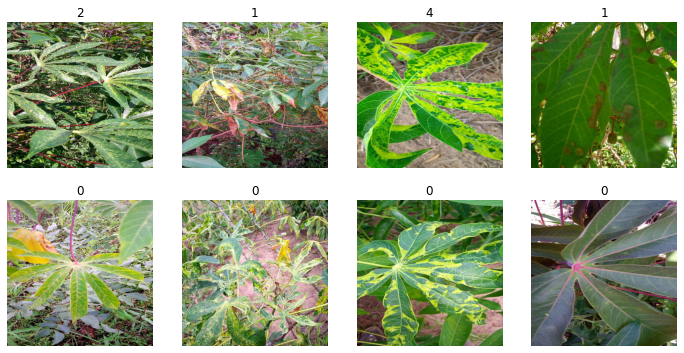

In [23]:
#Center crop 
#src https://docs.fast.ai/vision.augment#CropPad
dblock = dblock.new(item_tfms=CropPad(500))
dlsCrop = dblock.dataloaders(df_train_tidy, bs=64)
dlsCrop.train.show_batch(max_n=16, nrows=2)

In [24]:
mystop

NameError: name 'mystop' is not defined

## Xtra

In [ ]:
#$xtra not efficient - runs out of memory
#--functions
#define label lookup 
def lookup_image_code(image_code): 
    return df_train[df_train['image_id_cat_code']== image_code]['image_id']

#test function
#lookup_image_code(1)

In [ ]:
#$xtra not efficient - runs out of memory
df_train_tidy = df_train_res.copy()
print(df_train_tidy.shape)
df_train_tidy['image_id_res'] = None
print(df_train_tidy.shape)
df_train_tidy['image_id_res'] = df_train_tidy['image_id_cat_code'].apply(lookup_image_code)
df_train_tidy.head()


- with item resize

In [ ]:
dls = ImageDataLoaders.from_name_func(
    path, train_img, valid_pct=0, seed=SEED, bs=8,
    label_func=lookup_label, item_tfms=Resize(224)) #

dls.train.show_batch(max_n=16, nrows=2)